In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import seaborn as sb

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.isna().any()

ticker    False
date      False
last      False
volume    False
dtype: bool

In [4]:
df.drop(df[df["volume"]==0].index, inplace = True)

In [5]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [6]:
close = df.pivot(index='date', columns='ticker', values='last')
close = close.rename_axis(None, axis=0)
close = close.rename_axis(None, axis=1)
volume = df.pivot(index='date', columns='ticker', values='volume')
volume = volume.rename_axis(None, axis=0)
volume = volume.rename_axis(None, axis=1)

In [7]:
returns = close.pct_change()

/var/folders/m7/3vl2z1js2wqgh_chrm_mncfr0000gn/T/ipykernel_3032/3478380900.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = close.pct_change()


In [8]:
price_volume_corr = -volume.rolling(5).corr(close).shift()

/Users/guanjielinghu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/guanjielinghu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:ylabel='Count'>

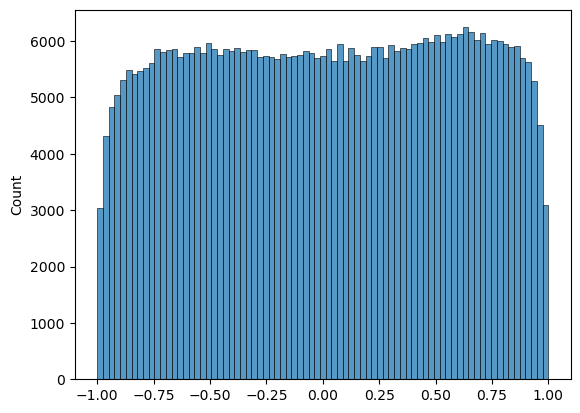

In [9]:
sb.histplot(data=price_volume_corr.values.flatten())


In [10]:
price_volume_corr[abs(price_volume_corr)<0.8] = np.nan

/Users/guanjielinghu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/guanjielinghu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:ylabel='Count'>

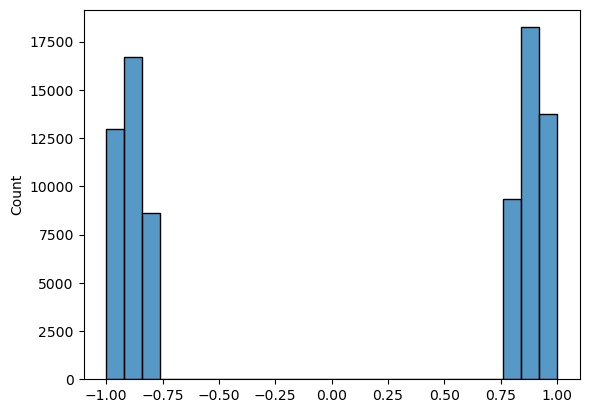

In [11]:
sb.histplot(data=price_volume_corr.values.flatten())

In [12]:
alpha = price_volume_corr
alpha = alpha.loc[alpha.first_valid_index():]
returns = returns.loc[alpha.first_valid_index():]

In [13]:
def get_portfolio_daily_return(factor_df, return_df, index_list, group_num):

    portfolio_daily_return = return_df.copy()[[]]
    portfolio_holding = pd.DataFrame(index = return_df.index, columns = return_df.columns)
    portfolio_holding.loc[:,:] = np.nan
    holding_count = return_df.copy()[[]]
    turnover = pd.DataFrame(index = index_list)


    for i in range(len(index_list)):
        stock_list = factor_df.loc[index_list[i]].dropna().sort_values(ascending = False).index.to_list()
        start = return_df.index.get_loc(index_list[i]) + 1
        if i != len(index_list)-1:
            end = return_df.index.get_loc(index_list[i + 1]) + 1
        else:
            end = len(index_list)
        for j in range(group_num - 1):
            group = stock_list[j * round(len(stock_list)/group_num): (j + 1) * round(len(stock_list)/group_num)]
            portfolio_daily_return.loc[portfolio_daily_return.index[start:end],\
                                       "group_{}".format(j + 1)] =\
            return_df.iloc[start:end][group].mean(axis = 1)
            holding_count.loc[holding_count.index[start:end],\
                                       "group_{}".format(j + 1)] = len(group)
            
            portfolio_holding.loc[portfolio_holding.index[start:end], group] = j+1
            
            if i > 0:
                last_portfolio = portfolio_holding.loc[portfolio_holding.index[start-1]]
                turnover.loc[turnover.index[i], "group_{}".format(j + 1)] =\
                len(set(group).intersection(set(last_portfolio[last_portfolio == j+1].index.to_list())))/len(set(last_portfolio[last_portfolio == j+1].index.to_list()))

            
        group = stock_list[(group_num-1) * round(len(stock_list)/group_num):]
        portfolio_daily_return.loc[portfolio_daily_return.index[start:end],\
                                   "group_{}".format(group_num)] =\
        return_df.iloc[start:end][group].mean(axis = 1)
        holding_count.loc[holding_count.index[start:end],\
                                       "group_{}".format(group_num)] = len(group)
            
        portfolio_holding.loc[portfolio_holding.index[start:end], group] = group_num
        if i > 0:
            last_portfolio = portfolio_holding.loc[portfolio_holding.index[start-1]]
            turnover.loc[turnover.index[i], "group_{}".format(group_num)] =\
            len(set(group).intersection(set(last_portfolio[last_portfolio == group_num].index.to_list())))/len(set(last_portfolio[last_portfolio == group_num].index.to_list()))
        
    return portfolio_daily_return, turnover, holding_count

In [14]:
def get_portfolio_cum_return(portfolio_daily_return):
    
    return (portfolio_daily_return + 1).cumprod()

In [15]:
def information_analysis(period_return, period_factor):
    
    IC = period_factor.copy()[[]]
    for date in IC.index:
        
        
        stock_list = list(set(period_factor.loc[date].dropna().index.to_list())\
        .intersection(period_return.loc[date].dropna().index.to_list()))

        IC.loc[date, "IC"], p = pearsonr(\
                                         period_return.loc[date, stock_list],\
                                         period_factor.loc[date, stock_list])
        IC.loc[date, "RIC"], p = spearmanr(\
                                         period_return.loc[date, stock_list],\
                                         period_factor.loc[date, stock_list])
    mean_IC = IC["IC"].mean()
    mean_RIC = IC["RIC"].mean()
    std_IC = IC["IC"].std()
    std_RIC = IC["RIC"].std()
    
    return [mean_IC, std_IC, mean_IC/std_IC], [mean_RIC, std_RIC, mean_RIC/std_RIC]

In [16]:
def maxdrawdown(prices):
    max_price = float('-inf')
    max_drawdown = 0
    for i in range(len(prices)):
        if prices[i] > max_price:
            max_price = prices[i]
        elif (prices[i] - max_price) / max_price < max_drawdown:
            max_drawdown = (prices[i] - max_price) / max_price

    return max_drawdown

In [17]:
def annual_sharpe_ratio(period_return, period):
    
    return period_return.mean() * (252/period) / (period_return.std() * (252/period) ** 0.5)
  

In [18]:
index_list = alpha.loc[alpha.first_valid_index():].index
group_num = 3

In [19]:
portfolio_daily_return, turnover, holding_count = get_portfolio_daily_return(alpha, returns, index_list, group_num)

In [20]:
turnover

,group_1,group_2,group_3
2013-01-11,NaN,NaN,NaN
2013-01-15,0.545455,0.272727,0.250000
2013-01-16,0.250000,0.125000,0.250000
2013-01-17,0.250000,0.416667,0.545455
2013-01-18,0.500000,0.100000,0.666667
...,...,...,...
2021-03-15,0.153846,0.076923,0.416667
2021-03-16,0.176471,0.000000,0.125000
2021-03-17,0.375000,0.000000,0.375000
2021-03-18,0.625000,0.250000,0.142857


In [21]:
turnover.mean()

group_1    0.318075
group_2    0.142989
group_3    0.305508
dtype: float64

In [22]:
turnover.groupby(turnover.index.year).mean()

,group_1,group_2,group_3
2013,0.300304,0.144669,0.312818
2014,0.337436,0.133518,0.305322
2015,0.350276,0.149902,0.305329
2016,0.329907,0.158511,0.300074
2017,0.299320,0.130137,0.310035
2018,0.314298,0.133892,0.284058
2019,0.312750,0.147695,0.307692
2020,0.306386,0.143534,0.310546
2021,0.288044,0.153714,0.345211


In [23]:
holding_count.iloc[1:].sum(axis = 1).max()

187.0

In [24]:
holding_count.iloc[1:].sum(axis = 1).min()

4.0

In [25]:
portfolio_cum_return = get_portfolio_cum_return(portfolio_daily_return)

Text(0.5, 1.0, '3 Group Backtesting')

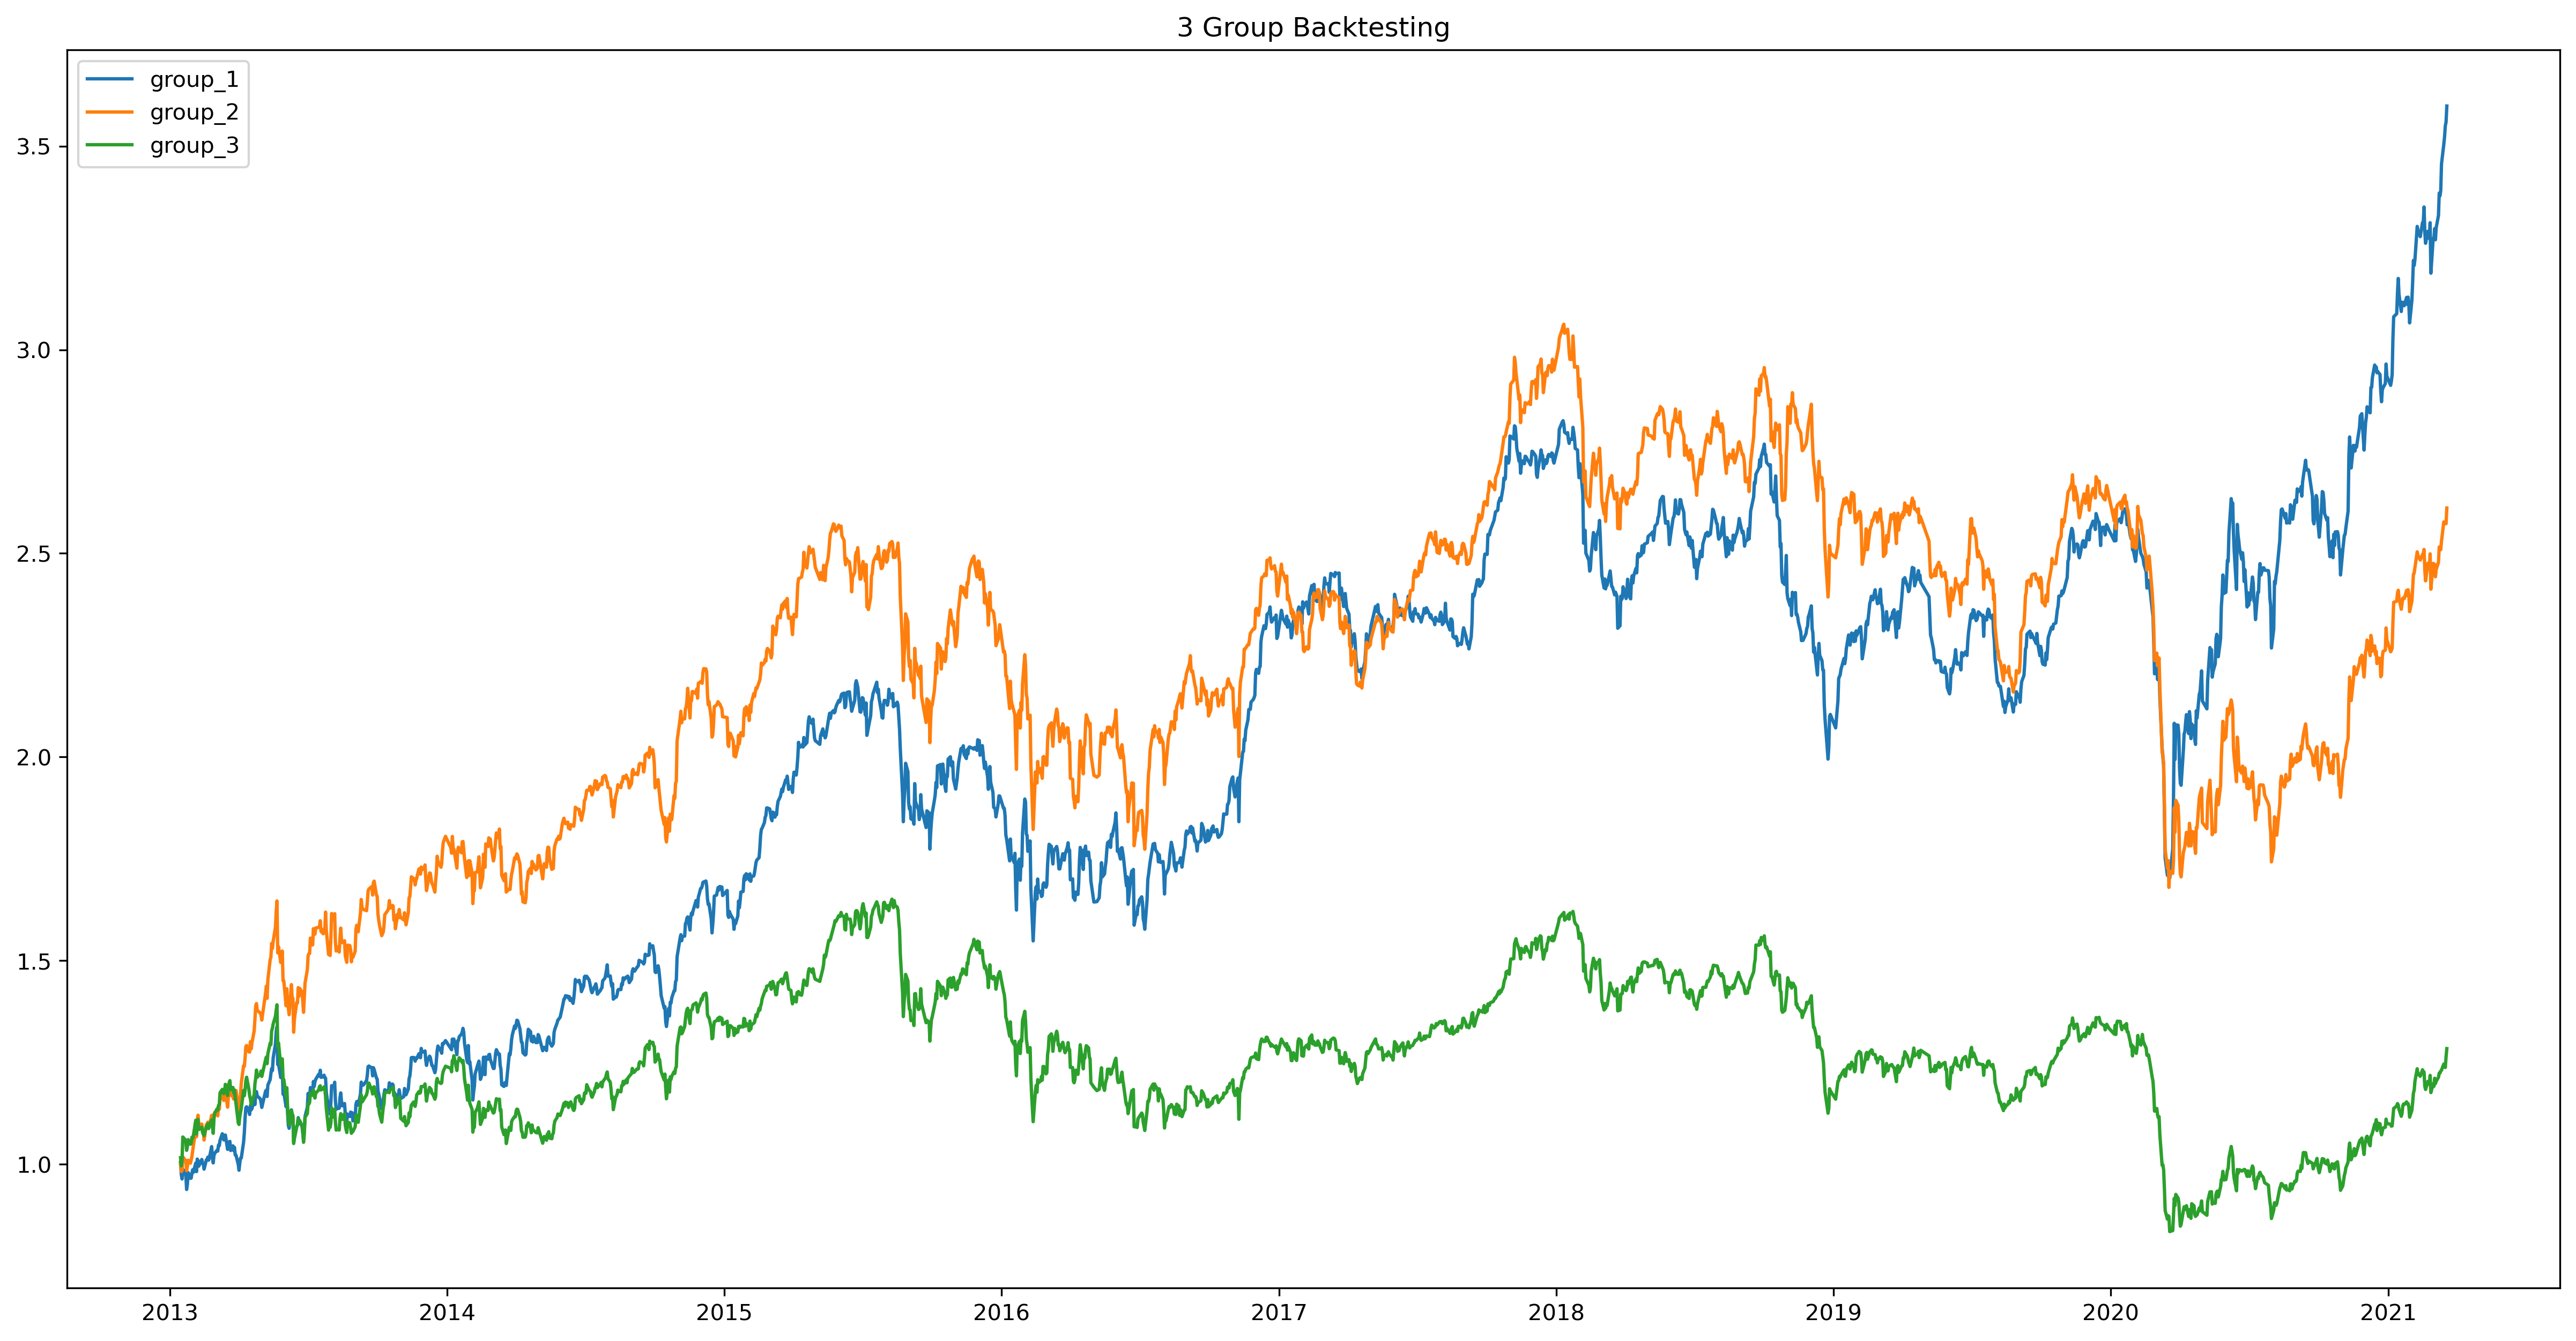

In [26]:
plt.figure(figsize = (20,10), dpi = 300)
plt.plot(portfolio_cum_return)
plt.legend(portfolio_cum_return.columns)
plt.title("3 Group Backtesting")

Text(0.5, 1.0, 'Long-Short Portfolio Performance')

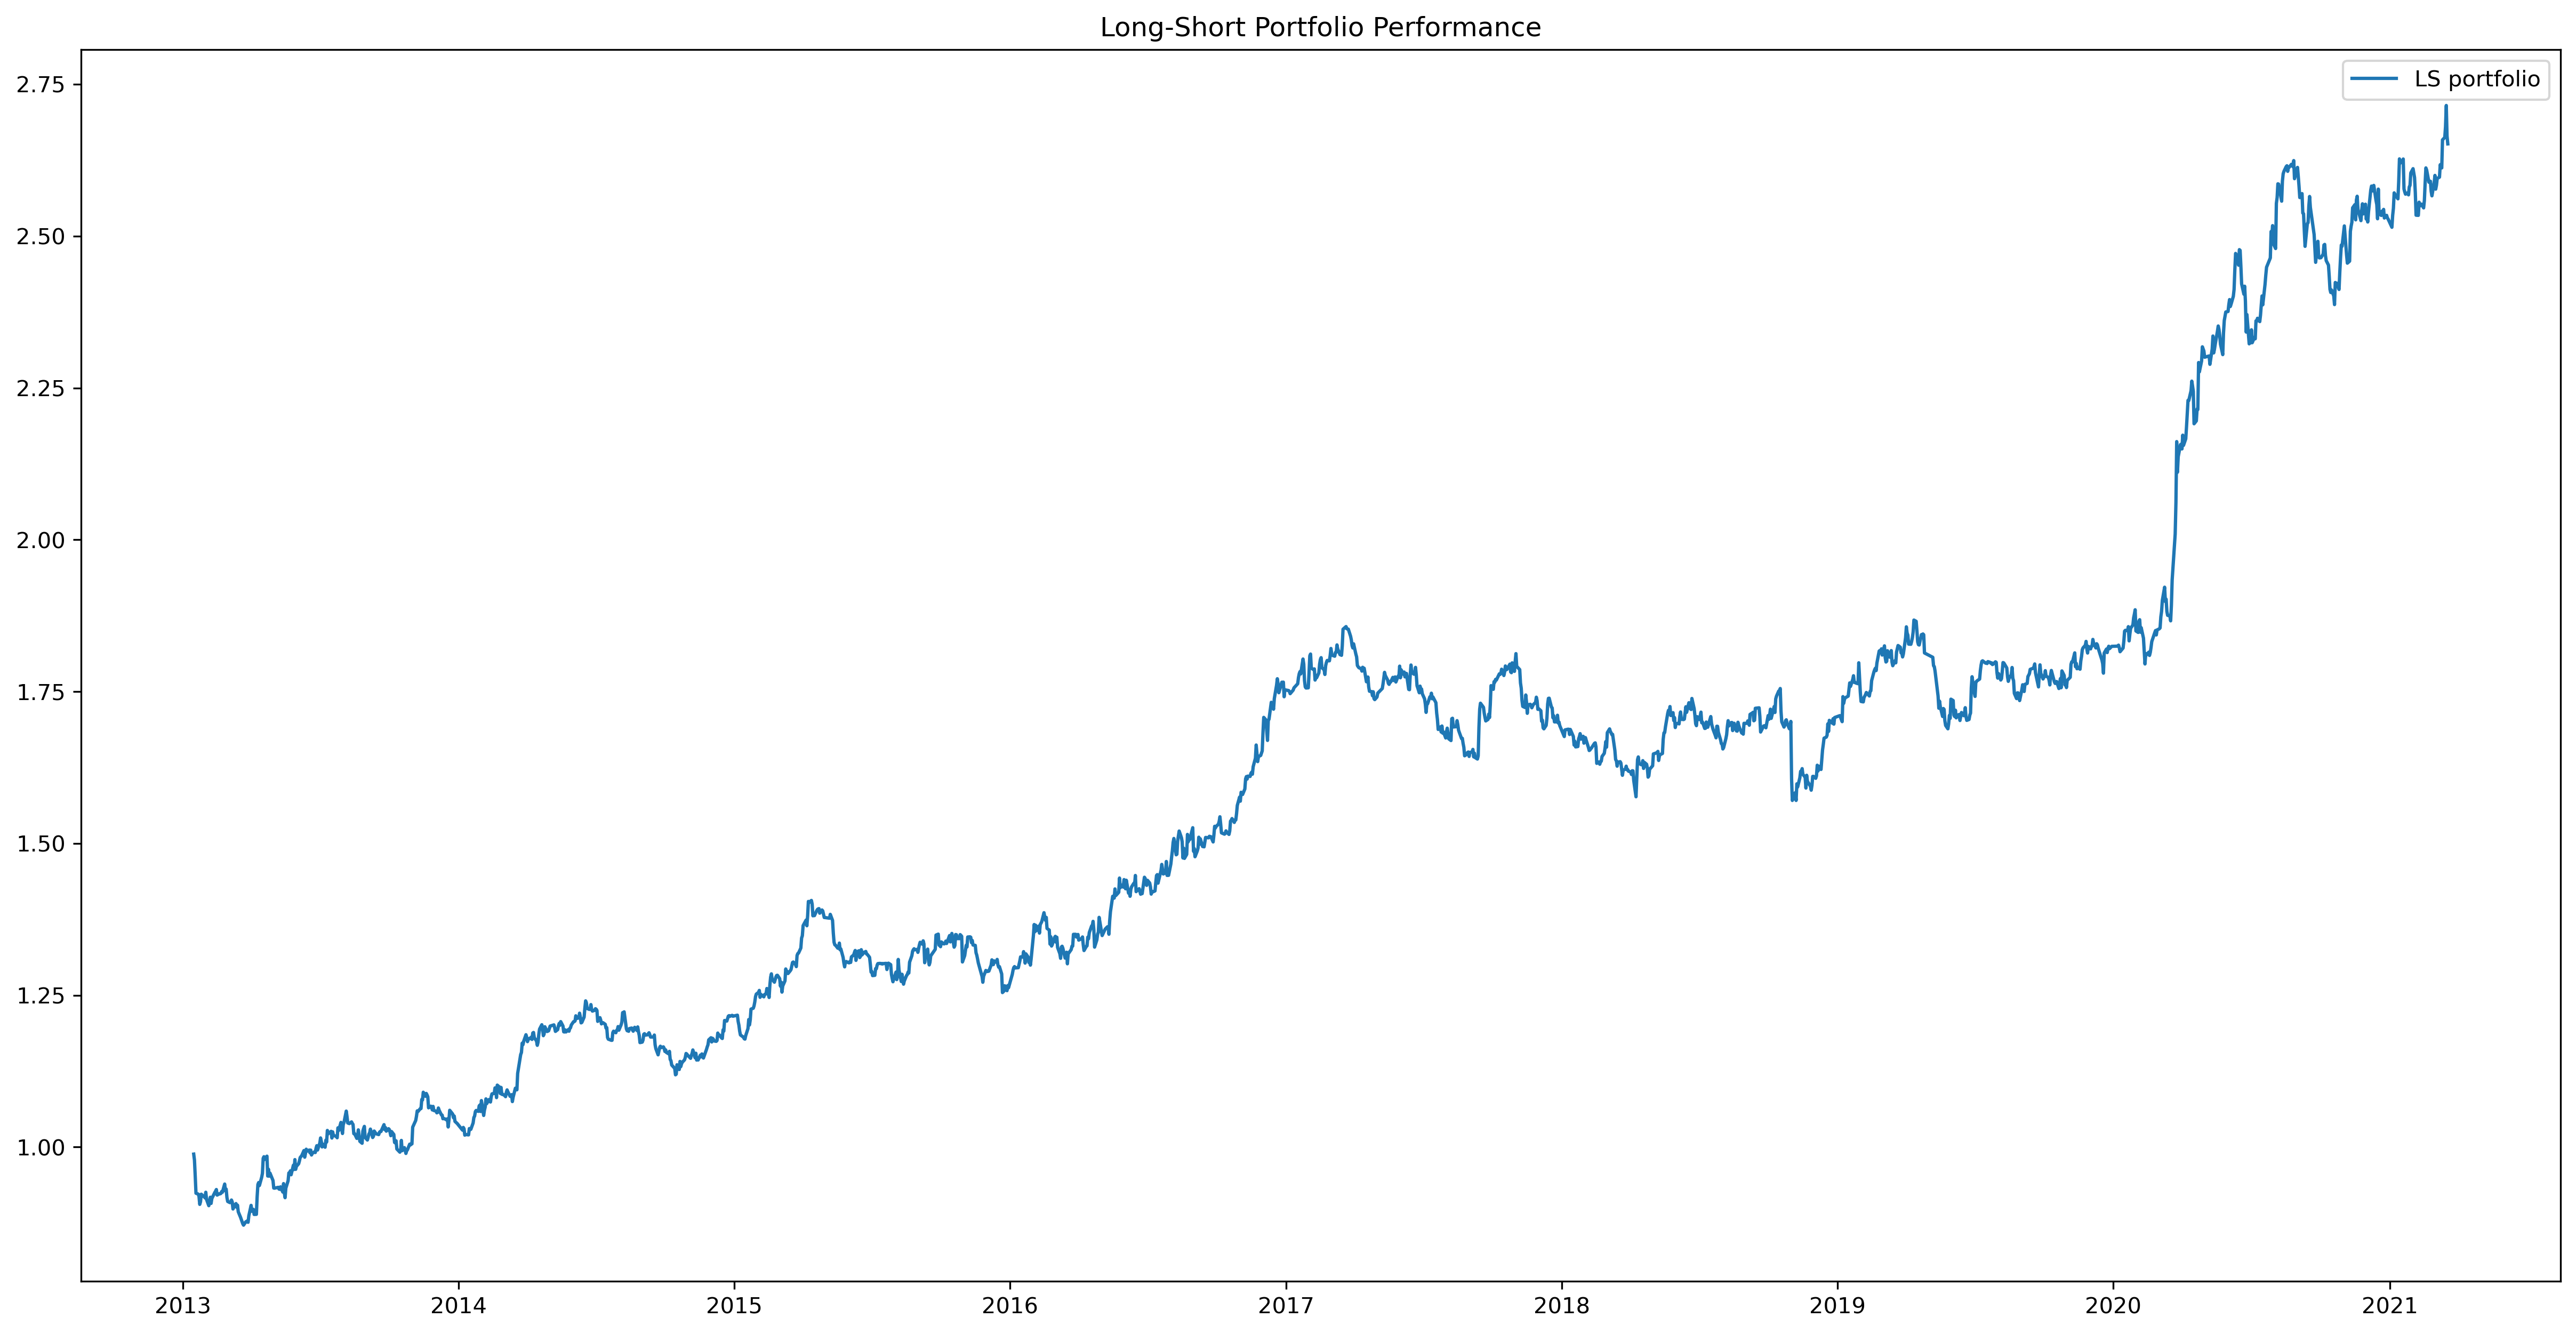

In [27]:
plt.figure(figsize = (20,10), dpi = 300)
plt.plot(get_portfolio_cum_return(portfolio_daily_return["group_1"]- portfolio_daily_return["group_3"]))
plt.legend(["LS portfolio"])
plt.title("Long-Short Portfolio Performance")

In [28]:
annual_sharpe_ratio(portfolio_daily_return["group_1"]- portfolio_daily_return["group_3"], 1)

1.0517551973063006

In [29]:
maxdrawdown(get_portfolio_cum_return(portfolio_daily_return["group_1"]- portfolio_daily_return["group_3"]))

/var/folders/m7/3vl2z1js2wqgh_chrm_mncfr0000gn/T/ipykernel_3032/2941434159.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if prices[i] > max_price:
/var/folders/m7/3vl2z1js2wqgh_chrm_mncfr0000gn/T/ipykernel_3032/2941434159.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (prices[i] - max_price) / max_price < max_drawdown:
/var/folders/m7/3vl2z1js2wqgh_chrm_mncfr0000gn/T/ipykernel_3032/2941434159.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

-0.15418022838557222

### Summary

This strategy is a market-neutral strategy constructed based on a short-term extreme price-volume correlation factor, with a calculation period of one week. Stocks within the portfolio are allocated with equal weights. All stocks in each cross-section are sorted based on the factor values into three groups, and the first and third groups are selected to form the long and short positions respectively.

Important backtesting results:
annualized sharpe ratio: 1.05, 
max draw down: 15%, 
turnover ratio: 30%.

Based on the backtesting results, the performance seems acceptable. However, the coverage of this strategy would be a big problem. The lowest coverage is only 4, which indicates that the capacity of this strategy would also be very low.

Conclusion: This strategy is only suitable for investing small amount of money.